In [18]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# 1. Data Loading and Preprocessing


In [19]:
# Load datasets
rejected_data = pd.read_csv('/Users/eduardoangeli/Desktop/Capstone/Dataset/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv')
accepted_data = pd.read_csv('/Users/eduardoangeli/Desktop/Capstone/Dataset/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')


# Label datasets: 1 for accepted and 0 for rejected
accepted_data['label'] = 1
rejected_data['label'] = 0

# Rename columns in rejected dataset to match accepted dataset
rejected_data.rename(columns={'Amount Requested': 'loan_amnt', 'Debt-To-Income Ratio': 'dti'}, inplace=True)

# Select and align columns for merging
selected_columns = ['home_ownership', 'annual_inc', 'loan_amnt', 'dti', 'emp_length', 'last_fico_range_low', 'label']
for column in selected_columns:
    if column not in rejected_data.columns:
        rejected_data[column] = None

# Merge datasets
merged_data = pd.concat([accepted_data[selected_columns], rejected_data[selected_columns]], axis=0).reset_index(drop=True)

# Handle missing values
for column in ['home_ownership', 'emp_length']:
    merged_data[column].fillna(merged_data[column].mode()[0], inplace=True)
for column in ['annual_inc', 'last_fico_range_low']:
    merged_data[column].fillna(merged_data[column].median(), inplace=True)

# Convert dti values to numerical format and handle missing values
merged_data['dti'] = merged_data['dti'].str.rstrip('%').astype('float') / 100.0
merged_data['dti'].fillna(merged_data['dti'].median(), inplace=True)

/var/folders/r6/9sr46wnj2jnbq3yrgp4bf0c80000gn/T/ipykernel_1915/2825445454.py:3: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_data = pd.read_csv('/Users/eduardoangeli/Desktop/Capstone/Dataset/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')


# 2. Feature Engineering

In [20]:
# One-hot encoding categorical columns
encoded_data = pd.get_dummies(merged_data, columns=['home_ownership', 'emp_length'])

# Splitting data and scaling features
X = encoded_data.drop(columns=['last_fico_range_low', 'label'])
y = merged_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Handle NaN values
if np.isnan(X_train_scaled).any():
    nan_columns = np.where(np.isnan(X_train_scaled).any(axis=0))[0]
    for col in nan_columns:
        col_mean = np.nanmean(X_train_scaled[:, col])
        X_train_scaled[np.isnan(X_train_scaled[:, col]), col] = col_mean
        X_test_scaled[np.isnan(X_test_scaled[:, col]), col] = col_mean

# 3. Model Training and Evaluation

In [21]:
# Train logistic regression model
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = classifier.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)

# 4. Residual Analysis

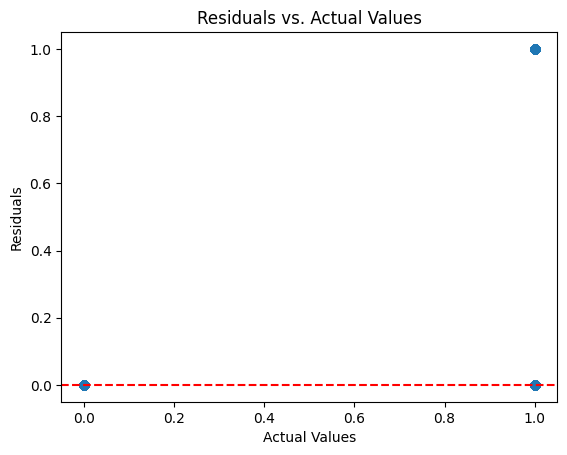

In [22]:
# Calculate residuals and plot
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

# 5. Return value to the user

In [23]:
def generate_random_user():
    """Generate a random example of a new user."""
    
    # Randomly select values for each feature
    home_ownership = np.random.choice(['MORTGAGE', 'RENT', 'OWN'])
    annual_inc = np.random.uniform(20000, 150000)  # Random income between 20k and 150k
    loan_amnt = np.random.uniform(500, 40000)  # Random loan amount between $500 and $40k
    dti = np.random.uniform(0.1, 0.9)  # Random dti between 10% and 90%
    emp_length = np.random.choice(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                                   '6 years', '7 years', '8 years', '9 years', '10+ years'])
    
    # Creating a DataFrame for the user
    user_data = pd.DataFrame({
        'home_ownership': [home_ownership],
        'annual_inc': [annual_inc],
        'loan_amnt': [loan_amnt],
        'dti': [dti],
        'emp_length': [emp_length]
    })
    
    # One-hot encoding
    user_encoded = pd.get_dummies(user_data, columns=['home_ownership', 'emp_length'])
    
    # Ensuring the user_encoded has all the columns that the model expects
    # If not, they're filled with zeros (because of one-hot encoding)
    missing_cols = set(X_train.columns) - set(user_encoded.columns)
    for col in missing_cols:
        user_encoded[col] = 0
        
    # Reordering columns to match the order the model was trained on
    user_encoded = user_encoded[X_train.columns]
    
    return user_encoded

def predict_approval_status(user_encoded):
    """Predict approval status for the given user."""
    
    # Scaling the user's data
    user_scaled = scaler.transform(user_encoded)
    
    # Predicting using the trained model
    prediction = classifier.predict(user_scaled)[0]
    
    return "Approved" if prediction == 1 else "Rejected"

# Generate a random user and predict their approval status
random_user = generate_random_user()
approval_status = predict_approval_status(random_user)